In [5]:
# Load the necessary libraries
import pandas as pd

# Load the CSV file into a DataFrame
file_path = '../data/CU.GRTK.00.BHZ.M.2024-09-06T000000.019539.csv'
df = pd.read_csv(file_path, comment='#')

#Time, Sample 2024-09-06T00:00:00.019539Z, 7046


# Convert DATE and TIME to a single datetime column and round up to the next hour
df['DATETIME'] = pd.to_datetime(df['Time'])
#df['DATETIME'] = df['DATETIME'].dt.ceil('h')  # Round to the next hour

# Set DATETIME as the index
df.set_index('DATETIME', inplace=True)

df_data = df[[' Sample']]


In [6]:
df_data.head()

,Sample
DATETIME,
2024-09-06 00:00:00.019539+00:00,7046
2024-09-06 00:00:00.044539+00:00,6225
2024-09-06 00:00:00.069539+00:00,6959
2024-09-06 00:00:00.094539+00:00,6878
2024-09-06 00:00:00.119539+00:00,6834


In [9]:
df_data.shape

(9600, 1)

In [17]:
import numpy as np

# Assuming the DataFrame has 9600 rows and DATETIME as index

# Create groups based on the number of rows to achieve the target number of samples
df_data['group'] = np.repeat(np.arange(7200), 9600 // 1800 + 1)[:len(df_data)]

# Downsample by taking the mean of each group
downsampled_df = df_data.groupby('group').max()

# Remove the temporary 'group' column if needed
#downsampled_df.drop(columns='group', inplace=True)

# Display the resulting downsampled DataFrame
downsampled_df.head()

,Sample
group,
0,7550
1,8189
2,9394
3,9704
4,10475


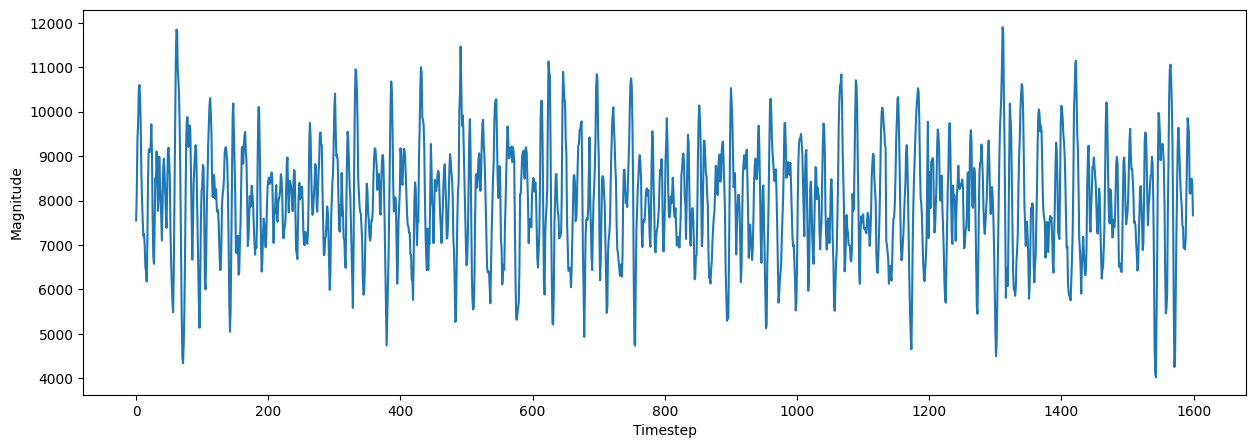

In [18]:
#graph
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(downsampled_df.index,downsampled_df[" Sample"])
plt.xlabel('Timestep')
plt.ylabel('Magnitude')
plt.savefig("../img/seismic_realtime.png")

In [19]:
downsampled_df.to_csv("../data/seismic_1800.csv", index = True)

In [25]:
#normalize and park at 3600


# Assuming 'df' is already loaded and has the 'Sample' column
# Normalize the 'Sample' column using min-max normalization
normalized_sample = (downsampled_df[' Sample'] - downsampled_df[' Sample'].min()) / (downsampled_df[' Sample'].max() - downsampled_df[' Sample'].min())

# Create a new DataFrame with an index from 0 to 7199
new_df = pd.DataFrame(index=np.arange(7200))

# Fill the new DataFrame with 0.0 values initially
new_df[' Sample'] = 0.0

# Find the start index to center the data at index 3599
start_idx = 3599

# Place the normalized data in the new DataFrame starting at 'start_idx'
new_df.loc[start_idx:start_idx + len(normalized_sample) - 1, ' Sample'] = normalized_sample.values

# Display the resulting DataFrame
new_df.head(10), new_df.tail(10)


(   Sample
 0     0.0
 1     0.0
 2     0.0
 3     0.0
 4     0.0
 5     0.0
 6     0.0
 7     0.0
 8     0.0
 9     0.0,
       Sample
 7190     0.0
 7191     0.0
 7192     0.0
 7193     0.0
 7194     0.0
 7195     0.0
 7196     0.0
 7197     0.0
 7198     0.0
 7199     0.0)

In [26]:
new_df.dtypes

Sample    float64
dtype: object

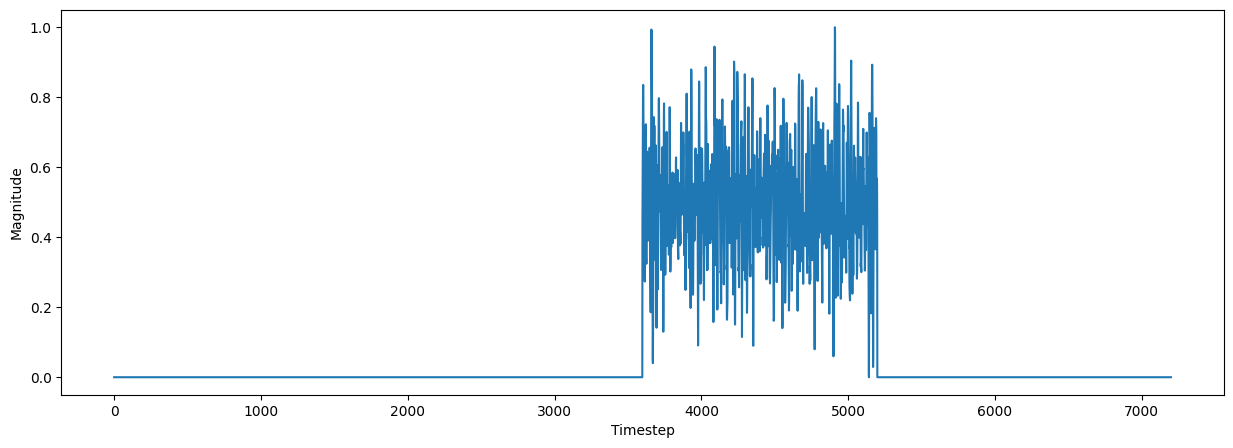

In [28]:
plt.figure(figsize=(15, 5))
plt.plot(new_df.index,new_df[" Sample"])
plt.xlabel('Timestep')
plt.ylabel('Magnitude')
plt.savefig("../img/seismic_realtime_7200.png")